In [1]:
import torch
import h5py
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import beta
from torch.special import psi
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
import copy
import math
import wandb
import os
import yaml
import time
import gc
import datetime
import optuna
import zarr
import seaborn as sns
from scipy import stats

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()

c:\Users\maild\miniconda3\envs\mldrivenpeled\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_twocarrier_3.1V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_single_carrier_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/time_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/normalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V_scale2.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_test_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.13V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_25MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale8.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_4MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_3e5-4MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-4MHz_3.5V_scale2.zarr"
file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/test/channel_3e5-15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-30MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_1e4-15MHz_3.5V_scale4.zarr"

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
# device = torch.device("cpu")
print(device)


WIDE_BAND = False
TIME_MODEL = True

cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

if os.path.exists(cache_path):
    data = torch.load(cache_path, map_location=device)
    sent_frames_time = data["sent_frames_time"].to(device)
    received_frames_time_resampled = data["received_frames_time"].to(device)
    FREQUENCIES = data["frequencies"].to(device)
    NUM_POINTS_SYMBOL = data["NUM_POINTS_SYMBOL"]
    CP_LENGTH = data["CP_LENGTH"]
    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    print(NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND)
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2

    print("Loaded from cache!")
else:
    print("No cache found — loading original dataset...")

    H5 = False
    FREQUENCIES = None
    if H5:
        # Extract all frame data
        DTYPE = torch.complex64
        sent = []
        received = []
        received_time = []
        FREQUENCIES = None
        with h5py.File(file_path, "r") as f:
            # Get frequency
            first_frame = list(f.keys())[-1]
            FREQUENCIES = torch.tensor(f[first_frame]['freqs'][:], dtype=DTYPE).to(device).real
            NUM_POINTS_SYMBOL = int(f[first_frame]['num_points_symbol'][()])
            CP_LENGTH = int(f[first_frame]['cp_length'][()])
            for frame in f:
                group = f[frame]
                sent.append(torch.tensor(group['sent'][:], dtype=DTYPE))
                received.append(torch.tensor(group['received'][:], dtype=DTYPE))
                received_time.append(torch.tensor(group['received_time'][:], dtype=DTYPE))
    else:
        # Open the Zarr root
        root = zarr.open(file_path, mode="r")

        # Get first frame

        # Load metadata (attributes live under .attrs)
        sent, received, received_time = [], [], []

        # Loop through frames
        num_skipped = 0
        for frame_key in root.group_keys():
            try:
                frame = root[frame_key]
                if FREQUENCIES is None:
                    FREQUENCIES = torch.tensor(frame["freqs"][:], dtype=torch.int).real
                    NUM_POINTS_SYMBOL = int(frame.attrs["num_points_symbol"])
                    CP_LENGTH = int(frame.attrs["cp_length"])
                else:
                    pass

                sent.append(torch.tensor(frame["sent"][:], dtype=torch.complex64))
                received.append(torch.tensor(frame["received"][:], dtype=torch.complex64))
                if "received_time" in frame:
                    received_time.append(torch.tensor(frame["received_time"][:], dtype=torch.float32))
            except:
                num_skipped += 1
                pass # skip corrupted frames
    print(f"Skipped {num_skipped} corrupted frames")

    sent_frames = torch.stack(sent).squeeze(1)
    sent_frames_active = sent_frames
    received_frames = torch.stack(received).squeeze(1)


    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2


    def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
        # Make hermetian symmetric
        Nt, Nf = X.shape
        padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
        leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
        X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
        DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
        X_hermitian = torch.flip(X, dims=[1]).conj()
        X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])

        # Convert to time domain
        x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
        return x_time.to(device)

    if len(received_time) > 0:
        N_shortest = min(t.size(-1) for t in received_time)
        N_longest = max(t.size(-1) for t in received_time)
        good_indices = [i for i, x in enumerate(received_time) if x.size(-1) == N_shortest]
        received_frames_time = torch.stack([t for t in received_time if t.size(-1) == N_shortest], dim=0).real.squeeze(1)
        sent_frames = sent_frames[good_indices]


    sent_frames_time = symbols_to_time(sent_frames, UPSAMPLING_ZEROS, NUM_ZEROS)
    # Add cyclic prefix
    sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))
    received_frames_time = received_frames_time - received_frames_time.mean(dim=1, keepdim=True)



    # enforce OSA causality
    # sent_frames_time = sent_frames_time[:, :-1]
    # received_frames_time_resampled = received_frames_time_resampled[:,  1:]
    sent_frames_time = sent_frames_time.to(device)
    received_frames_time = received_frames_time.to(device)

    TRUNCATE_SIZE = slice(CP_LENGTH, CP_LENGTH + 100)
    sent_frames_time = sent_frames_time[:, TRUNCATE_SIZE]
    received_frames_time = received_frames_time[:, TRUNCATE_SIZE]

    # Create a cache path
    cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

    torch.save({
        "sent_frames_time": sent_frames_time.cpu(),
        "received_frames_time": received_frames_time.cpu(),
        "frequencies": FREQUENCIES.cpu(),
        "NUM_POINTS_SYMBOL": NUM_POINTS_SYMBOL,
        "CP_LENGTH": CP_LENGTH
    }, cache_path)

class ChannelData(Dataset):
        def __init__(self,
                    sent_frames,
                    received_frames,
                    frequencies,
                    transform=None,
                    target_transform=None):

            self.sent_frames = sent_frames
            self.received_frames = received_frames
            assert len(sent_frames) == len(received_frames)

        def __len__(self):
            return len(self.sent_frames)

        def __getitem__(self, idx):
            return self.sent_frames[idx], self.received_frames[idx]

if TIME_MODEL:
    dataset = ChannelData(sent_frames_time, received_frames_time, FREQUENCIES)
else:
    dataset = ChannelData(sent_frames, received_frames, FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator()
)
print("Train Size", train_size)

cuda
No cache found — loading original dataset...
Skipped 0 corrupted frames
Train Size 1801


(100,) (100,)


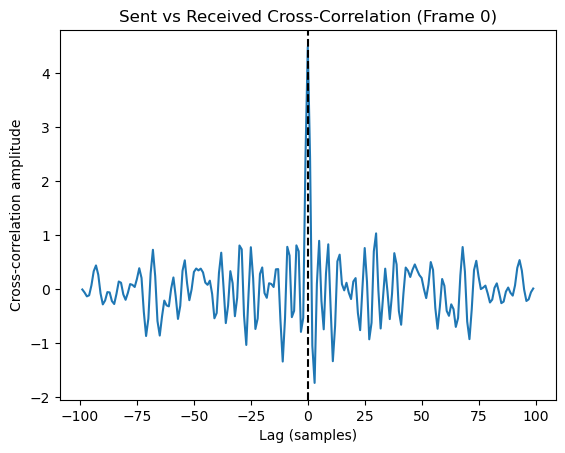

Peak lag: 0


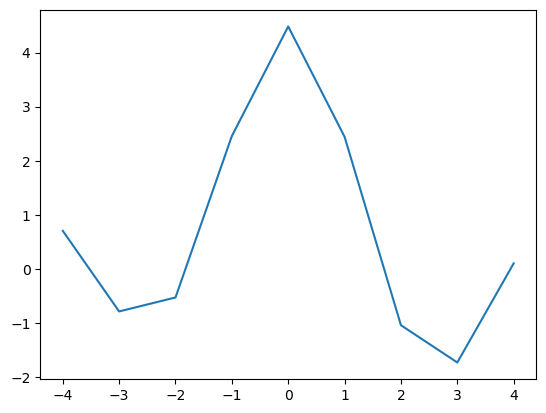

In [3]:
s = sent_frames_time[100].cpu().numpy()
r = received_frames_time[100].cpu().numpy()

print(s.shape, r.shape)
corr = np.correlate(s, r, mode='full')
T = len(s)
zero_lag_index = T - 1

lags = np.arange(-T + 1, T)  # lag axis
plt.plot(lags, corr)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation amplitude')
plt.title('Sent vs Received Cross-Correlation (Frame 0)')
plt.show()

# Find best alignment
best_lag = lags[np.argmax(corr)]
print("Peak lag:", best_lag)

window = 4
lags = np.arange(-window, window + 1)
plt.plot(lags, corr[zero_lag_index - window:zero_lag_index + window + 1])

In [13]:
      
class StateSpaceModel(nn.Module):
    def __init__(self,
                 deterministic_num_taps,
                 deterministic_state_size,
                 deterministic_hidden_size,
                 stochastic_state_size,
                 stochastic_hidden_size
                 ):
        super().__init__()
        self.deterministic_state_size = deterministic_state_size
        self.stochastic_state_size = stochastic_state_size
        self.deterministic_num_taps = deterministic_num_taps
        self.deterministic_state_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + deterministic_state_size, deterministic_hidden_size),
            nn.ReLU(),
            nn.Linear(deterministic_hidden_size, deterministic_hidden_size),
            nn.ReLU(),
            nn.Linear(deterministic_hidden_size, deterministic_state_size)
        )
        self.deterministic_out_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + deterministic_state_size, deterministic_hidden_size),
            nn.ReLU(),
            nn.Linear(deterministic_hidden_size, deterministic_hidden_size),
            nn.ReLU(),
            nn.Linear(deterministic_hidden_size, 1) # Predict next scalar ouptut
        )
        self.stochastic_state_map = nn.Sequential(
            nn.Linear(stochastic_state_size + deterministic_num_taps + 1, stochastic_hidden_size),
            nn.ReLU(),
            nn.Linear(stochastic_hidden_size, stochastic_hidden_size),
            nn.ReLU(),
            nn.Linear(stochastic_hidden_size, stochastic_state_size)
        )
        self.stochastic_out_map = nn.Sequential(
            nn.Linear(deterministic_num_taps + stochastic_state_size + deterministic_state_size, stochastic_hidden_size),
            nn.ReLU(),
            nn.Linear(stochastic_hidden_size, stochastic_hidden_size),
            nn.ReLU(),
            nn.Linear(stochastic_hidden_size, 1)
        )

        self.n0 = nn.Parameter(torch.zeros(deterministic_state_size))
        self.z0 = nn.Parameter(torch.zeros(stochastic_state_size))
    def forward(self, x, y):
        device = x.device
        y_pred = torch.zeros_like(y, device=device)
        e_pred = torch.zeros_like(y, device=device)
        T = x.size(-1)
        B = x.size(0)
        # n_t = torch.zeros(B, self.deterministic_state_size, device=device)
        # z_t = torch.zeros(B, self.stochastic_state_size, device=device)
        # use learned initial states, broadcast to batch
        n_t = self.n0.unsqueeze(0).expand(B, -1)  # [B, nx]
        z_t = self.z0.unsqueeze(0).expand(B, -1)  # [B, nz]
        # add zeros in front equal to num_taps - 1
        x = torch.cat([torch.zeros(B, self.deterministic_num_taps - 1, device=device), x], dim=-1)
        for t in range(T):
            x_t = x[:, t: t + self.deterministic_num_taps]
            y_t = y[:, t]
            y_t_pred = self.deterministic_out_map(torch.cat([x_t, n_t], dim=-1))
            r_t = y_t.unsqueeze(-1) - y_t_pred
            nonlinear_noise_t = self.stochastic_out_map(torch.cat([x_t, n_t, z_t], dim=-1))
            y_t_next_pred = y_t_pred + nonlinear_noise_t
            y_pred[:, t] = y_t_next_pred.squeeze(-1)
            e_t = r_t - nonlinear_noise_t
            e_pred[:, t] = e_t.squeeze(-1)
            # Make state updates
            z_t = self.stochastic_state_map(torch.cat([x_t, z_t, r_t.detach()], dim=-1))
            n_t = self.deterministic_state_map(torch.cat([x_t, n_t], dim=-1)) # [B, nx + num_taps]
        return y_pred, e_pred

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0
        )
        self.padding = (kernel_size - 1) * dilation
        self.relu = nn.ReLU()
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        out = F.pad(x, (self.padding, 0))
        out = self.conv(out)
        out = self.relu(out)
        # bilinear_out = x * out
        if self.resample:
            x = self.resample(x)
        return out + x  # residual connection


def sample_student_t_mps(mean, std, nu):
    '''
    Wilson-Hilferty Approximation for chi^2 converted to scaled and shifted student t
    '''
    z = torch.randn_like(mean)
    z_chi = torch.randn_like(mean)
    chi2_approx = nu * (1 - 2/(9*nu) + z_chi * torch.sqrt(2/(9*nu))).pow(3)
    scale = torch.sqrt(nu / (chi2_approx + 1e-6))
    return mean + std * z * scale


class TCN(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        # Calculate the total receptive field for the whole TCN stack
        self.receptive_field = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            self.receptive_field += (num_taps - 1) * dilation

    def forward(self, xin1):
        x = xin1.unsqueeze(1)   # [B,1,T]
        # xin2 = xin2.unsqueeze(1)   # [B,1,T]
        # x = torch.cat([xin1, xin2], dim=1)   # [B,2,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1)
        # out = out - out.mean(dim=1, keepdim=True)  # [B,T]
        return out


class TCN_noise_model(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32, gaussian=True):
        super().__init__()
        layers = []
        in_channels = 2 # rin
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        if gaussian:
            self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1) # 1 channels
        self.num_taps = num_taps
        self.gaussian = gaussian

    def forward(self, xin, rin):
        xin = xin.unsqueeze(1)
        rin = rin.unsqueeze(1)
        x = torch.cat([xin, rin], dim=1)    # [B,2,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1) # [B, T]
        return out


class TCN_channel(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32, learn_noise=False, gaussian=True):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.learn_noise = learn_noise
        self.tcn = nn.Sequential(*layers)
        if gaussian:
            self.readout = nn.Conv1d(hidden_channels, 2, kernel_size=1) # 2 channels mean | std
        else:
            self.readout = nn.Conv1d(hidden_channels, 3, kernel_size=1) # 3 channels mean | std | nu
        self.num_taps = num_taps
        self.gaussian = gaussian

        if not gaussian:
            with torch.no_grad():
                # Initialize log_nu bias
                self.readout.bias[2].fill_(48)

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        # x = torch.cat([x, torch.square(x)], dim=1)
                # add y delayed
        # y_lag = torch.roll(y_in, shifts=1, dims=1)
        # y_lag[:, 0] = 0.0
        # x = torch.stack([xin, xi], dim=1)
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out) # [B, 3, T] mean | std | nu
        mean_out = out[:, 0, :]
        log_std_out = out[:, 1, :]
        std_out = torch.exp(log_std_out)
        # std_out = torch.clamp(std_out, min=1e-6)
        if not self.gaussian:
            log_nu_out = out[:, 2, :]
            nu_out = torch.nn.functional.softplus(log_nu_out)
            # nu_out = torch.exp(log_nu_out)
            nu_out = torch.clamp(nu_out, 2, 50) # nu between 2 and 50
        mean_out = mean_out - mean_out.mean(dim=1, keepdim=True)  # [B ,T]

        # # Produce noisy output
        if self.gaussian:
            z = torch.randn_like(mean_out)
            noisy_out = mean_out + std_out * z
            nu_out = torch.zeros_like(mean_out)
        else:
            noisy_out = sample_student_t_mps(mean_out, std_out, nu_out)
        if self.learn_noise:
            return noisy_out, mean_out, std_out, nu_out
        else:
            return mean_out, mean_out, torch.zeros_like(mean_out), torch.zeros_like(mean_out)


class CausalCNNChannel(nn.Module):
    def __init__(self, nlayers=4, hidden=32, kernel=13, gaussian=True, learn_noise=False):
        super().__init__()
        layers = []
        for i in range(nlayers):
            layers.append(nn.Conv1d(
                in_channels=1 if i==0 else hidden,
                out_channels=hidden,
                kernel_size=kernel,
                padding=kernel-1,   # temporary padding
            ))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

        self.gaussian = gaussian
        self.learn_noise = learn_noise
        self.readout = nn.Conv1d(hidden, 2 if gaussian else 3, kernel_size=1)

    def forward(self, xin):
        x = xin.unsqueeze(1)
        out = self.net(x)
        out = out[..., :xin.size(-1)]
        out = self.readout(out)
        mean = out[:,0]
        mean = mean - mean.mean(dim=1, keepdim=True)
        std = torch.exp(out[:,1])
        if self.gaussian:
            return mean, mean, std, torch.zeros_like(mean)
        else:
            nu = torch.nn.functional.softplus(out[:,2]) + 2
            noisy = sample_student_t_mps(mean, std, nu)
            return noisy, mean, std, nu

In [14]:
def visualize_std(model, input_tensor):
    model.eval()
    with torch.no_grad():
        noisy_sample, mean_pred, std_pred, _ = model(input_tensor)

    xin = input_tensor[0].cpu().numpy()
    mean = mean_pred[0].cpu().numpy()
    std = std_pred[0].cpu().numpy()
    sample = noisy_sample[0].cpu().numpy()

    time_steps = np.arange(len(xin))

    plt.figure(figsize=(14, 7))

    plt.plot(time_steps, mean, label='Predicted Mean', color='blue', linewidth=2)

    plt.fill_between(
        time_steps,
        mean - 2 * std,
        mean + 2 * std,
        color='blue',
        alpha=0.2,
        label='Uncertainty (±2σ)'
    )

    plt.plot(time_steps, sample, label='Generated Sample', color='green', alpha=0.7)

    plt.title('Model Prediction with Learned Uncertainty')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()

In [15]:
def regularizer(model, rho_theta, tau, rho_w):
    # θ = all parameters of both models
    l2_theta = 0.0
    l1_theta = 0.0
    for p in list(model.parameters()):
        l2_theta = l2_theta + torch.sum(p ** 2)
        l1_theta = l1_theta + torch.sum(p.abs())

    # \hat w_0 = [n0, z0] from the state-space model
    # adjust if w0 should also include noise-model initial states
    w0_vec = torch.cat([model.n0.view(-1), model.z0.view(-1)])
    l2_w0 = torch.sum(w0_vec ** 2)

    reg = 0.5 * rho_theta * l2_theta + tau * l1_theta + 0.5 * rho_w * l2_w0
    return reg

def train(model, optimizer, loop, config):
    model.train()
    total_loss = 0
    batch_count = 0
    thetas = []
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred, e_pred = model(x, y)
        loss = torch.mean((e_pred ** 2)) + regularizer(model, config.rho_theta, config.tau, config.rho_w)
        mse_loss = F.mse(y, y_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        wandb.log({"innovation_train_loss": loss.item()})
        wandb.log({"mse_train_loss": mse_loss.item()})
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
    loop.close()

def val(model, val_loader, config, slice_length):
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    val_mse_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            mean_y, e_pred = model(x, y)
            y_preds.append(mean_y)
            LOSS_INDICES = slice(slice_length, -slice_length)
            loss = torch.mean((e_pred ** 2))
            mse_loss = F.mse(y, mean_y)
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            batch_count += 1
    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)
    wandb.log({
        "val_innovation_loss": avg_val_loss,
        "avg_val_mse_loss": avg_val_mse_loss
    })
    return avg_val_loss


In [17]:
script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "state_space_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

# Start Weights and Biases session
wandb.init(project="mldrivenpeled",
           config=hyperparams, tags=['channel_model'])
config = wandb.config

RECEPTIVE_FIELD = (1 + (config.num_taps - 1) * (config.dilation_base**config.nlayers - 1) // (config.dilation_base - 1))


print(f"WandB run info:")
print(f"  Name: {wandb.run.name}")
print(f"  ID: {wandb.run.id}")
print(f"  URL: {wandb.run.url}")
print("Chosen hyperparameters for this session:")
print(config)


# Create dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)
test_loader = DataLoader(test_dataset)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)

channel_model = StateSpaceModel(
    deterministic_num_taps=10,
    deterministic_hidden_size=4,
    stochastic_hidden_size=4,
    stochastic_state_size=1,
    deterministic_state_size=1
).to(device)

initial_model_state = copy.deepcopy(channel_model.state_dict())

optimizer = optim.AdamW(list(channel_model.parameters()), lr=config.lr, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

num_epochs = config.epochs
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    train(channel_model, optimizer, loop, config)
    avg_val_loss = val(channel_model, val_loader, config)
    scheduler.step(avg_val_loss)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(channel_model):,}")
# Freeze model
for param in channel_model.parameters():
    param.requires_grad = False

# Save model
torch.save({
    "channel_model": channel_model.state_dict(),
}, "channel_model_final.pth")

artifact = wandb.Artifact("channel_model", type="model")
artifact.add_file("channel_model_final.pth")
wandb.log_artifact(artifact)
print("Finished!")
run_name = wandb.run.name
wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


WandB run info:
  Name: peach-field-6330
  ID: 5t7cyy0a
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/5t7cyy0a
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 32, 'num_taps': 10, 'epochs': 10, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 8, 'dilation_base': 2, 'num_points_symbol': 4000, 'learn_noise': True, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'gaussian': True, 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4', 'dc_offset': 3.5}


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'rho_theta'

In [ ]:
def correlation(x: torch.Tensor, y: torch.Tensor, lag_max: int) -> torch.Tensor:
    '''
    Computes batched and normalized correlation between x and y [B, N] up to lag_max times
    '''
    x_centered = x - x.mean(dim=-1, keepdims=True)
    y_centered = y - y.mean(dim=-1, keepdims=True)
    cross_corrs = []
    N = x_centered.shape[1]
    assert lag_max <= N, "Lag max too long"
    x_rms = torch.sqrt((1 / N) * torch.sum(x_centered ** 2, dim=-1, keepdims=True))
    y_rms = torch.sqrt((1 / N) * torch.sum(y_centered ** 2, dim=-1, keepdims=True))
    for lag in range(-lag_max, lag_max+1):
        if lag >= 0:
            shifted_x = x_centered[:, lag:]
            shifted_y = y_centered[:, :N-lag]
        else:
            shifted_x = x_centered[:, :N+lag]
            shifted_y = y_centered[:, -lag:]

        corr = torch.mean(shifted_x * shifted_y, dim=-1)
        corr_norm = torch.mean(corr / (x_rms * y_rms)) # Average across batches
        cross_corrs.append(corr_norm)
    return torch.stack(cross_corrs, dim=0)


def compute_billings_corrs(batched_residuals: torch.Tensor, batched_inputs: torch.Tensor, lag_max: int):
    '''
    Computs the Billing's et al correlation parameters to determine whether a model
    has captured the system's nonlinearity

    Args:
        batched_residuals: model errors of shape [B, N]
        batched_inputs: model inputs of shape [B, N]
    '''

    confidence_value = 1.96 / np.sqrt(batched_residuals.shape[1])
    lags = lags = np.arange(-lag_max, lag_max + 1)

    phi_r_r = correlation(batched_residuals, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_r_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Residual Autocorrelation")
    plt.legend()
    plt.show()
    phi_u_r = correlation(batched_inputs, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Input-Residual Correlation")
    plt.legend()
    plt.show()
    shifted_product = batched_residuals[:, 1:] * batched_inputs[:, 1:]
    phi_r_ru = correlation(batched_residuals[:, :-1], shifted_product, lag_max).cpu().numpy()
    plt.plot(lags, phi_r_ru)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Residual (RU)")
    plt.legend()
    plt.show()
    u_prime_squared = torch.square(batched_inputs) - torch.mean(batched_inputs ** 2, dim=-1, keepdim=True)
    phi_u_prime_squared_r = correlation(u_prime_squared, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_prime_squared_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("(U^2)' Residual")
    plt.legend()
    plt.show()
    phi_u_prime_squared_r_squared = correlation(u_prime_squared, batched_residuals ** 2, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_prime_squared_r_squared)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("(U^2)' Residual ^2")
    plt.legend()
    plt.show()

innovations = []
all_residuals = []
all_nu = []
all_std = []
all_inputs = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        all_inputs.append(x[:, RECEPTIVE_FIELD:])
        y = y.to(device)
        y_pred, e_pred = channel_model(x, y)
        # # Compute standardized residuals
        # r = y - y_pred
        # # shift r s.t. only past residuals t-1 are available to the noise model
        # r_shifted = torch.roll(r, shifts=1, dims=1)
        # # zero-out the first timestep (no past residual available)
        # r_shifted[:, 0] = 0.0
        # v_pred = noise_model(x, r_shifted)
        # e_pred = r - v_pred

        innovations.append(e_pred[:, RECEPTIVE_FIELD:])

from statsmodels.stats.diagnostic import acorr_ljungbox
all_inputs_tensor = torch.cat(all_inputs, dim=0)[:100, CP_LENGTH:]
all_innovations_tensor = torch.cat(innovations, dim=0)[:100, CP_LENGTH:]


# Ensure they are 0 mean
all_inputs_tensor -= all_inputs_tensor.mean(dim=-1, keepdim=True)
all_innovations_tensor -= all_innovations_tensor.mean(dim=-1, keepdim=True)

all_inputs_np  = all_inputs_tensor.cpu().numpy()
all_residuals_np  = all_innovations_tensor.cpu().numpy()

sns.reset_defaults()      # resets seaborn styles
plt.rcParams.update(plt.rcParamsDefault)

print(all_inputs_tensor.shape, all_innovations_tensor.shape)

ljung_box = 0
cross_corr = 0
auto_corr = 0
for i in range(all_inputs_np.shape[0]):
    input_seq = all_inputs_np[i]
    residual_seq = all_residuals_np[i]
    x = acorr_ljungbox(residual_seq, lags=[20])
    ljung_box += x['lb_pvalue'].values[0]
    cross_corr += np.correlate(input_seq, residual_seq, mode='full')
    auto_corr += np.correlate(residual_seq, residual_seq, mode='full')
ljung_box /= all_inputs_np.shape[0]
cross_corr /= all_inputs_np.shape[0]
auto_corr /= all_inputs_np.shape[0]


# Find zero-lag index
zero_index = auto_corr.shape[0] // 2

lag_window = 200
lags = np.arange(-lag_window, lag_window)

auto_window = auto_corr[-lag_window + zero_index: zero_index + lag_window]
cross_window = cross_corr[-lag_window + zero_index: zero_index + lag_window]

auto_window /= auto_corr[zero_index]
cross_window /= np.max(np.abs(cross_window)) # normalize so signal energy does not dominate

# Ljung-Box test for autocorrelation
print(f"Ljung-Box Value {ljung_box:.4f})")
sns.set_theme()
# # Plot autocorrelation
# plt.plot(lags, auto_window)
# plt.title("Residual Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Normalized Corr")
# plt.show()

# plt.plot(lags, cross_window)
# # plt.axvline(RECEPTIVE_FIELD, color='red', linestyle='--', label='Receptive Field')
# plt.title("Input-Residual Cross-Correlation (Raw Residuals)")
# plt.xlabel("Lag")
# plt.ylabel("Normalized Corr")
# # plt.legend()
# plt.show()

print(type(all_innovations_tensor), type(all_inputs_tensor))
compute_billings_corrs(all_innovations_tensor, all_inputs_tensor, 20)

In [ ]:

import matplotlib.cm as cm


t = torch.linspace(0, 1, NUM_POINTS_FRAME)


freqs = torch.arange(K_MIN, 3000)[::100]

# # Downsample frequency sweep
# freqs = KS[::200].cpu()


# print(freqs)
freq_step_hz = 10e3
freqs_hz = freqs * freq_step_hz


fig, ax = plt.subplots(figsize=(10, 10))

# Normalize by real frequency values
norm = plt.Normalize(vmin=min(freqs_hz), vmax=max(freqs_hz))
cmap = cm.get_cmap('viridis')



def loop_area(x, y):
    # x, y are 1D numpy arrays
    return 0.5 * np.trapezoid(y, x)

areas = []
for f_idx, f_hz in zip(freqs, freqs_hz):
    x = 3 * torch.sin(2 * np.pi * f_idx * t).unsqueeze(0).to(device)
    _, y, _, _ = channel_model(x)

    x = x.squeeze().cpu().numpy()[RECEPTIVE_FIELD:]
    y = y.squeeze().cpu().numpy()[RECEPTIVE_FIELD:]

    ax.scatter(x, y, color=cmap(norm(f_hz)), s=0.5, alpha=0.5)
    areas.append(loop_area(x,y))


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Frequency (kHz)")
tick_vals = np.linspace(min(freqs_hz), max(freqs_hz), 6)
cbar.set_ticks(tick_vals)
cbar.set_ticklabels((tick_vals.numpy() / 1e3).astype(int))  # display in kHz

ax.set_title("Model Prediction for Sinusoidal Inputs at Various Frequencies")
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


plt.plot(freqs, areas)
plt.xlabel("Frequency (10 kHz)")
plt.ylabel("Loop Area (Memory Index)")
plt.title("Dynamic Nonlinearity vs Frequency")
plt.show()


In [ ]:
script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_channel_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    print(f"WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

def objective(trial, tag):
    # Sample hyperparameters
    dilation_base = trial.suggest_categorical("dilation_base", [2])
    num_taps = trial.suggest_int("num_taps", 10, 256, step=2)
    hidden_channels = trial.suggest_int("hidden_channels", 4, 64, step=8)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    nlayers = trial.suggest_categorical("nlayers", [2])

    local_config = {
        "dilation_base": dilation_base,
        "num_taps": num_taps,
        "hidden_channels": hidden_channels,
        "lr": lr,
        "epochs": 50,
        "batch_size": 16,
        "Nt": 1,
        "Nf": 599,
        "save_path": "./saved_models",
        "nlayers": nlayers,
        "weight_init": "default",
        "scheduler_type": "reduce_lr_on_plateu",
        "learn_noise": True,
        "gaussian": True
    }

    wandb.init(project="mldrivenpeled", config=local_config, reinit=True,
               tags=['autoencoder', f'{tag}', f'trial {trial.number}'], mode='online')

    channel_model = None
    optimizer = None
    scheduler = None

    try:

        channel_model = TCN_channel(
            nlayers=local_config['nlayers'],
            dilation_base=local_config['dilation_base'],
            num_taps=local_config['num_taps'],
            hidden_channels=local_config['hidden_channels'],
            learn_noise=local_config['learn_noise'],
            gaussian=True
        ).to(device)

        if channel_model.gaussian:
            loss_fn = gaussian_nll
        else:
            loss_fn = students_t_loss

        optimizer = torch.optim.Adam(
            list(channel_model.parameters()), lr=lr
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        for epoch in range(local_config['epochs']):
            loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{local_config["epochs"]}', leave=False)
            train_loss = train(channel_model, optimizer, loss_fn, loop, scheduler, train_ABC=False)
            val_loss = val(channel_model, loss_fn, val_loader, local_config)

        return val_loss

    finally:
        wandb.finish()
        time.sleep(0.5)

        del channel_model, optimizer, scheduler, loop

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
study_name = f"optuna_offline_channel_model_{timestamp}"
study = optuna.create_study(direction="minimize", study_name=study_name, storage="sqlite:///optuna_results.db", load_if_exists=True)
study.optimize(lambda trial: objective(trial, study_name), n_trials=50)
print("Best trial:")
print(study.best_trial.params)

In [ ]:
storage = "sqlite:///optuna_results.db"

'''

{'dilation_base': 2, 'num_taps': 18, 'hidden_channels': 36, 'lr': 0.003526635762093742, 'nlayers': 3}
'''
summaries = optuna.get_all_study_summaries(storage=storage)
for summary in summaries:
    print(f"Study name: {summary.study_name}")
    print(f"  Trial count: {summary.n_trials}")
    if summary.best_trial is not None:
        print(f"  Best value: {summary.best_trial.value}")
        print(f"  Best params: {summary.best_trial.params}")
    else:
        print("  No trials completed yet.")
    print("-" * 50)

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

# Step 1: Choose your study name (copy it from the summaries you printed earlier)
study_name = "optuna_offline_channel_model_20251013_142218"
storage = "sqlite:///optuna_results.db"

# Step 2: Load the study
study = optuna.load_study(study_name=study_name, storage=storage)

# Step 3: Plot using interactive Plotly charts
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_slice(study).show()
plot_parallel_coordinate(study).show()

In [ ]:
study.best_trial

In [ ]:


train_sizes = (np.linspace(0.1, 1.0, 5) * len(train_dataset)).astype(int)
train_sizes = [int(s) for s in train_sizes]

all_val_losses = []
print(f"Testing training sizes: {train_sizes}")


wandb.init()
for size in tqdm(train_sizes):
    print(f"--- Training on {size} samples ---")

    subset_indices = train_dataset.indices[:size]
    train_subset = Subset(dataset, subset_indices)

    train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

    channel_model.load_state_dict(initial_model_state)
    channel_model.to(device)
    channel_model.train()

    optimizer = torch.optim.Adam(channel_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    NUM_EPOCHS = 3
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader_subset, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=False)
        train(channel_model, optimizer, loss_fn, loop, scheduler, train_ABC=False)
        avg_val_loss = val(channel_model, loss_fn, val_loader)
        scheduler.step(avg_val_loss)

    final_val_loss = val(channel_model, loss_fn, val_loader)
    all_val_losses.append(final_val_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, all_val_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel("Number of Training Samples", fontsize=12)
plt.ylabel("Final Validation Loss (log)", fontsize=12)
plt.title("Learning Curve for Channel Model", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Solve for least squares FIR channel model to get estimate of
# channel delay

print(sent_frames_time.shape, received_frames_time_resampled.shape)

def make_toeplitz(x: torch.tensor, L):
    N = len(x)
    toeplitz = torch.zeros(N, L, device=x.device)
    for i in range(N):
        for j in range(L):
            if i - j >= 0: # Grab lower left
                toeplitz[i, j] = x[i - j]
    return toeplitz

def construct_A_and_b(x_sent, y_received, L):
    N = x_sent.size(1)
    A = torch.zeros(L, L, device=x_sent.device)
    b = torch.zeros(L, device=x_sent.device)
    for xi, yi in zip(x_sent, y_received):
        X = make_toeplitz(xi, L)
        A += X.T @ X
        b += X.T @ yi
    return A, b

A, b = construct_A_and_b(sent_frames_time, received_frames_time_resampled, 20)
h_best = torch.linalg.lstsq(A.cpu(), b.cpu()).solution

In [ ]:
def calculate_mse(x_sent, y_received, h, L):
    """
    Calculates the Mean Squared Error for the given filter h.
    """
    B, N = x_sent.shape
    device = x_sent.device
    h = h.to(device)

    # 1. Pad the input on the left with L-1 zeros.
    x_padded = F.pad(x_sent, (L - 1, 0))

    # 2. Create the indices for the Toeplitz matrices.
    i = torch.arange(N, device=device).view(N, 1)
    j = torch.arange(L, device=device).view(1, L)

    # Fixed indexing - this ensures we get the right Toeplitz structure
    indices = i + j  # Shape (N, L)

    # Clamp indices to avoid any potential out-of-bounds access
    indices = torch.clamp(indices, 0, x_padded.shape[1] - 1)

    # 3. Create the batched Toeplitz matrix X
    X = x_padded[:, indices]  # Shape (B, N, L)


    # 5. Predict y for the entire batch using the filter h
    y_pred = X @ h

    # 6. Calculate the MSE
    mse = F.mse_loss(y_pred, y_received)

    return mse


L = 20

mse_value = calculate_mse(sent_frames_time, received_frames_time_resampled, h_best, L)

print(f"Mean Squared Error: {mse_value.item()}")

In [ ]:
plt.plot(h_best.abs().numpy())
plt.xlabel("Taps")
plt.ylabel("H Mag")

In [ ]:
def effective_length(h, alpha=0.98):
    h = np.asarray(h)
    energy = np.square(h)
    cumu = np.cumsum(energy)
    total = cumu[-1]
    L_eff = int(np.searchsorted(cumu, alpha * total)) + 1
    return L_eff
effective_length(h_best)